<img src="https://github.com/d9w/evolution/raw/master/imgs/logo.png" width="20%" align="right" style="margin:0px 20px">


# Evolutionary Algorithms

## Evolving Neural Networks with ES

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a>&nbsp;| Dennis G. Wilson, Yuri Lavinas, Paul Templier | <a href="https://d9w.github.io/evolution/">https://d9w.github.io/evolution/</a>

In order to visualize the environment in this notebook, you will need to install the following:

In [1]:
!apt-get install -y xvfb

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 29 not upgraded.
Need to get 7,814 kB of archives.
After this operation, 12.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd64 1:1.1.0-1build3 [71.8 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 x11-xkb-utils amd64 7.7+5build4 [172 kB]
Get:5 http://archiv

In [2]:
!pip install cma swig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.5/283.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 43.8 MB/s eta 0:00:00


In [3]:
 !pip install pyvirtualdisplay gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379497 sha256=e8b8c36310c8d27f336b1cffeb759d3cbadcf3200b99754a6afe1bf475051fe7
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


In [ ]:
#!pip install torch

# <a name="neuroevolution">3.</a> ES for Neuroevolution

Evolutionary strategies are intended for continuous optimization and can easily be applied to the optimization of neural network parameters, or *neuroevolution*.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
import numpy as np
import gymnasium as gym
import time

In [76]:
class NeuralNetwork(nn.Module):

    def __init__(self, input_shape, n_actions):
        super(NeuralNetwork, self).__init__()
        self.l1 = nn.Linear(input_shape, 64)
        self.l2 = nn.Linear(64, 64)
        self.l3 = nn.Linear(64, 64)
        self.l4 = nn.Linear(64, 64)
        self.lout = nn.Linear(64, n_actions)

    def forward(self, x):
        x = F.relu(self.l1(x.float()))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        return self.lout(x)

    def get_params(self):
        p = np.empty((0,))
        for n in self.parameters():
            p = np.append(p, n.flatten().cpu().detach().numpy())
        return p

    def set_params(self, x):
        start = 0
        for p in self.parameters():
            e = start + np.prod(p.shape)
            p.data = torch.FloatTensor(x[start:e]).reshape(p.shape)
            start = e

We'll add some visualization functionality to have the environment render directly in the notebook.

In [61]:
from pyvirtualdisplay import Display
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
pydisplay = Display(visible=0, size=(1400, 900))
pydisplay.start()
plt.ion();

Following the framework of evolutionary policy search, we will optimize a neural network representing a policy and maximize the total reward over a single episode using this policy.

In [62]:
def evaluate(ann, env, visul=True):
    obs, info = env.reset(seed=0)

    # Create the figure and axis only once before starting
    if visul:
        plt.figure(figsize=(8, 6))
        img = plt.imshow(env.render())
        plt.axis('off')
        plt.tight_layout()

    total_reward = 0
    while True:
        # Output of the neural net
        net_output = ann(torch.tensor(obs))
        # the action is the value clipped returned by the nn
        action = net_output.data.cpu().numpy().argmax()
        obs, reward, done, truncated, info = env.step(action)
        total_reward += reward

        if visul:
            img.set_data(env.render())
            display.display(plt.gcf())
            display.clear_output(wait=True)
            # Small sleep to allow rendering to complete properly
            time.sleep(0.01)

        if done:
            break

    if visul:
        plt.close()

    return total_reward

In [63]:
import base64
def evaluate_video(ann, env, visul=True):
    obs, info = env.reset(seed=0)
    total_reward = 0

    if visul:
        frames = []
        frames.append(env.render())

    while True:
        net_output = ann(torch.tensor(obs))
        action = net_output.data.cpu().numpy().argmax()
        obs, reward, done, truncated, info = env.step(action)
        total_reward += reward

        if visul:
            frames.append(env.render())

        if done:
            break

    if visul:
        # Convert frames to mp4 video
        from moviepy.editor import ImageSequenceClip
        from IPython.display import HTML

        clip = ImageSequenceClip(frames, fps=20)
        video_file = 'lunar_lander.mp4'
        clip.write_videofile(video_file, fps=20)

        # Display the video
        with open(video_file, 'rb') as f:
            video_data = f.read()

        display.display(HTML("""
        <video width="640" height="480" controls autoplay>
            <source src="data:video/mp4;base64,{0}" type="video/mp4">
        </video>
        """.format(base64.b64encode(video_data).decode())))

    return total_reward

We've configured this for discrete action spaces. We can see a random neural network on different environments like `CartPole-v0`, `MountainCar-v0`, and `LunarLander-v2`.

In [77]:
env = gym.make('LunarLander-v3', render_mode='rgb_array')
ann = NeuralNetwork(env.observation_space.shape[0], env.action_space.n)
#On genere un reseau de neurones aleatoires ici

In [78]:
evaluate_video(ann, env, visul=True)

Moviepy - Building video lunar_lander.mp4.
Moviepy - Writing video lunar_lander.mp4



Moviepy - Done !
Moviepy - video ready lunar_lander.mp4


np.float64(-673.5885210140851)

In order to evolve the parameters of this neural network, we will modify the parameters of the network using `set_params` with the genes of the new individual. In the evolutionary literature, this is referred to as a *direct encoding* as the neural network parameters are directly encoded in the genome.

In [79]:
def fitness(x, ann, env, visul=False):
    ann.set_params(x)
    return -evaluate(ann, env, visul=visul)
    #evaluation renvoie la fitness, les algorithmes utiliser minimise donc on met un moins

In [80]:
p = ann.get_params()
np.shape(p)
#Beaucoup de parametres : 1476 (=8*32 + 32*32 + 32*4 + ...)

(13316,)

We can first observe a random individual $x$.

In [81]:
x = np.random.rand(len(p))
-fitness(x, ann, env, visul=True)

np.float64(-119.05959591305864)

Let's try optimizing the policy using the simple $(\mu, \lambda)$ ES we proposed.

In [68]:
def mu_lambda(x, fitness, gens=200, lam=10, alpha=0.2, verbose=False):
    x_best = x
    f_best = fitness(x)
    fits = np.zeros(gens)
    for g in range(gens):
        N = np.random.normal(size=(lam, len(x)))
        F = np.zeros(lam)
        for i in range(lam):
            ind = x + N[i, :]
            F[i] = fitness(ind)
            if F[i] < f_best:
                f_best = F[i]
                x_best = ind
                if verbose:
                    print(g, " ", f_best)
        fits[g] = f_best
        mu_f = np.mean(F)
        std_f = np.std(F)
        A = F
        if std_f != 0:
            A = (F - mu_f) / std_f
        x = x - alpha * np.dot(A, N) / lam
    return fits, x_best

In [69]:
np.random.seed(654)
env = gym.make('LunarLander-v3', render_mode='rgb_array')
ann = NeuralNetwork(env.observation_space.shape[0], env.action_space.n)
x = np.random.randn(len(ann.get_params()))
f = lambda x : fitness(x, ann, env)
fits, x = mu_lambda(x, f, gens=10, lam=10, alpha=0.1, verbose=True)

0   341.782694025281
0   129.032312791221
0   122.07944056061237
2   116.16285526701837
3   109.66231813129443
7   53.06660642845468


In [70]:
fits

array([122.07944056, 122.07944056, 116.16285527, 109.66231813,
       109.66231813, 109.66231813, 109.66231813,  53.06660643,
        53.06660643,  53.06660643])

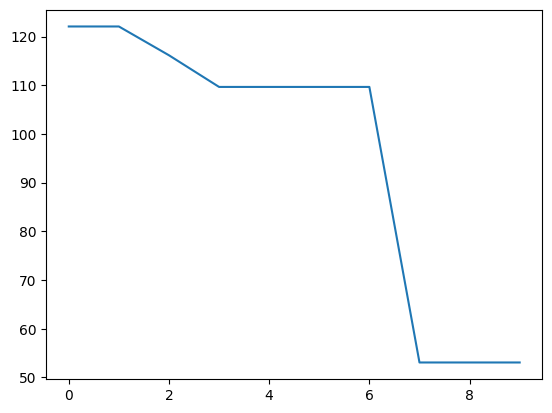

In [71]:
plt.plot(fits);

In [55]:
-fitness(x, ann, env, visul=True)

np.float64(-41.07745981749062)

# CMA-ES for Neuroevolution

We will now use CMA-ES for the Lunar Lander problem

In [82]:
import cma
np.random.seed(123)
env = gym.make('LunarLander-v3', render_mode='rgb_array')
ann = NeuralNetwork(env.observation_space.shape[0], env.action_space.n)
es = cma.CMAEvolutionStrategy(len(ann.get_params()) * [0], 0.1, {'seed': 123})

(16_w,32)-aCMA-ES (mu_w=9.2,w_1=19%) in dimension 13316 (seed=123, Wed Mar 26 10:27:23 2025)


In [86]:
for i in range(20):
    solutions = np.array(es.ask())
    fits = [fitness(x, ann, env) for x in solutions]
    es.tell(solutions, fits)
    es.disp()

   23    736 -6.147552273755224e+00 1.0e+00 9.83e-02  1e-01  1e-01 2:22.4
   26    832 -1.263174968122897e+01 1.0e+00 9.81e-02  1e-01  1e-01 2:41.3
   29    928 -2.228160607976449e+01 1.0e+00 9.80e-02  1e-01  1e-01 3:00.0
   32   1024 -3.807638224632981e+00 1.0e+00 9.78e-02  1e-01  1e-01 3:18.9
   35   1120 -2.775702916247963e+01 1.0e+00 9.76e-02  1e-01  1e-01 3:39.2
   38   1216 4.208435037241941e+00 1.0e+00 9.74e-02  1e-01  1e-01 3:57.7


In [88]:
x = es.result[0]
-fitness(x, ann, env, visul=True)

np.float64(67.0947258786448)

The results on LunarLander clearly show the benefits of CMA-ES; we have found a reasonable policy in a small number of generations. Applying CMA-ES to larger neural networks remains an open challenge, however, due to the vast number of parameters in ANNs. Specifically, CMA-ES calculates the covariance of all parameters, which is $O(n^2)$.

In [75]:
np.shape(es.sm.C)

(3588, 3588)

<div class="alert alert-success">
    <h3>Exercise 1</h3>
    
The network used has 2 layers of 32 neurons each. Try changing this and noticing the impact on the number of total parameters for CMA-ES. How large of a network can CMA-ES optimize?
</div>

<div class="alert alert-success">
    <h3>Exercise 2</h3>
    
Compare the $(1+\lambda)$ ES, $(\mu,\lambda)$ ES, and CMA-ES algorithms on Lunar Lander. Is one significantly better than the others, consistently across different initializations?
</div>